# STEP GL RECONSTRUCTION

In [52]:
from final_model import AudioDataset
from util import audio_utilities as au
import matplotlib.pyplot as plt
import numpy as np
import librosa as li
from IPython.display import Audio
from time import time

In [53]:
GC = AudioDataset("../notebooks/motu/motu_dataset/*.wav", process=False, slice_size=128)
print("Found %d samples." % len(GC))

Found 102 samples.


In [63]:
X = GC[0]

def show_spec(X):
    """Affiche un spectrogramme"""
    plt.figure(figsize=(15,10))
    plt.imshow(X, origin="lower", aspect="auto")
    plt.show()
    
def GL_1pass(X, partial=False):
    """Une passe de Griffin Lim. L'argument partial définit si l'intégralité de la phase est recherchée
    ou si juste la motié droite du spectrogramme est reconstruite"""
    N = X.shape[0]
    
    x = au.istft_for_reconstruction(X, 2048, 256)
    X_ = au.stft_for_reconstruction(x, 2048, 256)
    
    if partial:
        angle = np.angle(X_)
        Y = abs(X).astype(complex)
        Y[N//2:] *= np.exp(1j*angle[N//2:])
        Y[:N//2] = X[:N//2]
    else:
        angle = np.angle(X_)
        Y = abs(X).astype(complex)
        Y *= np.exp(1j*angle)
        
    return Y

def GL(X, iteration, partial=False):
    """Fais pleins de fois GL_1pass"""
    X = X.astype(complex)
    for i in range(iteration):
        X = GL_1pass(X, partial=partial)
    return X

def rec(X):
    return au.istft_for_reconstruction(X, 2048, 256)
    
    
    
mel = li.filters.mel(22050, 2048, 500)
X = mel.T.dot(X).T.astype(complex)
X_ = np.copy(X)

In [64]:
slice_size = 2
n_iter = 30
X[:slice_size] = GL(X[:slice_size], n_iter, partial=False)

# Reconstruction slice_size slices par slice_size slices.
start = time()
for i in range(1,X.shape[0]//slice_size):
    X[slice_size*(i-1):slice_size*(i+1)] = GL(X[slice_size*(i-1):slice_size*(i+1)], n_iter, partial=True)
assert time()-start < 1.57, "Reconstruction is not real time."

In [65]:
y = rec(X)
#y_ = au.reconstruct_signal_griffin_lim(X_, 2048, 256, 200)

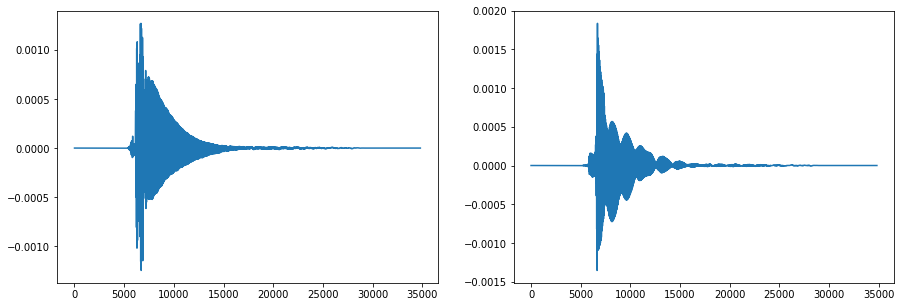

In [66]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(y)
plt.subplot(122)
plt.plot(y_)
plt.show()

In [67]:
Audio(np.concatenate([y,y_]), rate=22050)

In [40]:
len(y)/22050

1.5789569160997732